## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [6]:
# cd ..
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [7]:
pip install -r requirements.in --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [8]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr
from tqdm import tqdm
from odc.algo import mask_cleanup, xr_quantile
from concurrent.futures import ProcessPoolExecutor

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides
from intertidal.elevation import load_data, pixel_tide_sort, ds_to_flat, create_dask_gateway_cluster, abslmp_correction
from intertidal.utils import load_config

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
dc = datacube.Datacube(app='Intertidal_elevation')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/env/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44859 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/44859/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/44859/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37875,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/44859/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:32867,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/37221/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:46443,


## Setup


### Set analysis parameters

In [43]:
study_area = 507 ## 507 Roebuck Bay (also 506, 519)
fname = 'testing'
start_year = 2020
end_year = 2021
resolution = 30
crs = "epsg:32753"
ndwi_thresh = 0.1
include_s2 = True
include_ls = False

# Load analysis params from config file
config = load_config(
    config_path='configs/dea_intertidal_config.yaml')

### Load study area grid cell

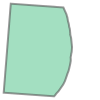

In [44]:
# Albers grid cells used to process the analysis
gridcell_gdf = (
    gpd.read_file(config['Input files']['grid_path']).to_crs(
        epsg=4326).set_index('id'))
gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# Create geom as input for dc.load
geom = Geometry(geom=gridcell_gdf.iloc[0].geometry, crs='EPSG:4326')
geom

##### Other options for loading study area

In [45]:
# # aoi = 'McCarthur River'
# # aoi = 'Greenbank'
# aoi = 'Seven Emu'
# # aoi = 'Wollogorang'

# # Import regions of interest
# aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
# aoi_gdf.head()

# # Select AOI
# geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
# geom

In [46]:
# from odc.ui import select_on_a_map
# from ipyleaflet import basemaps, basemap_to_tiles

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height='600px',
#                              layers=(basemap,),
#                              center=(-26, 135), 
#                              zoom=4)

## Load data

In [47]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/44859/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/44859/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37875,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/44859/status,Total threads: 15
Started: 3 hours ago,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:32867,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/37221/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:46443,


In [48]:
ds = load_data(dc=dc, 
               geom=geom, 
               time_range=(str(start_year), str(end_year)), 
               resolution=resolution, 
               crs=crs,
               s2_prod="s2_nbart_ndwi" if include_s2 else None,
               ls_prod="ls_nbart_ndwi" if include_ls else None,
               config_path=config['Virtual product']['virtual_product_path'])[['ndwi']]
# ds
# Load into memory
ds.load()

/env/lib/python3.8/site-packages/datacube/utils/geometry/_base.py:608: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return type(geom)([segmentize_shapely(g) for g in geom])


<xarray.Dataset>
Dimensions:      (time: 126, y: 1094, x: 759)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-14T02:12:22.280514 ... 2021-12...
  * y            (y) float64 7.972e+06 7.972e+06 ... 7.94e+06 7.939e+06
  * x            (x) float64 -8.513e+05 -8.513e+05 ... -8.286e+05 -8.286e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 nan nan nan nan ... -0.3764 -0.358 -0.3575
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

## Pixel-based tides
FES2014 source code: https://github.com/CNES/aviso-fes

34 tidal components

In [49]:
# Model tides into every pixel in the three-dimensional (x by y by time) satellite dataset
# ds["tide_m"], _ = pixel_tides(ds, resample=True, directory='~/tide_models')
ds["tide_m"], _ = pixel_tides(ds, resample=True, directory='~/dev_intexp/dea-notebooks/tide_models_clipped') # CP pointing to clipped tide models elsewhere in sandbox

# Set tide array pixels to nodata if the satellite data array pixels contain
# nodata. This ensures that we ignore any tide observations where we don't
# have matching satellite imagery 
ds["tide_m"] = ds["tide_m"].where(~ds.to_array().isel(variable=0).isnull())

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 126/126 [00:00<00:00, 141.87it/s]


## Pixel-based DEM creation

### Test pixel-wise rolling median
To conduct a pixel-wise rolling median, we first need to calculate some statistics on the tides observed for each individual pixel in the study area. These are then used to calculate rolling windows that are unique/tailored for the tidal regime of each pixel:
* `window_radius_tide`: Provides the radius/width of each rolling window in tide units (e.g. metres). 
* `window_spacing_tide`: Provides the spacing of each rolling window interval in tide units (e.g. metres)
* `window_offset`: Ensures that analysis covers the entire tide range by starting the first rolling window beneath the lowest tide, and finishing the final rolling window after the highest tide

### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../data/figures/tide_array_flattening.JPG)

In [50]:
# # Optionally apply ABSMLP tide correction
# ds = abslmp_correction(ds)

In [51]:
ds_flat, freq, good_mask = ds_to_flat(
    ds, ndwi_thresh=0.0, min_freq=0.01, max_freq=0.99, min_correlation=0.25
)

Reducing analysed pixels from 830346 to 61769 (7.44%)


In [52]:
# Calculate tide min, max, range
tide_max = ds_flat.tide_m.max(dim='time')
tide_min = ds_flat.tide_m.min(dim='time')
tide_range = tide_max - tide_min

# Choose number of rolling windows and radius of each window
windows_n = 100  # number of rolling windows to iterate over
window_prop_tide = 0.15  #  0.15  # proportion of the tide range to use for each window radius

# Calculate rolling window radius and spacing between each rolling window
window_radius_tide = tide_range * window_prop_tide  # Rolling window radius in tide/metre units
window_spacing_tide = tide_range / windows_n  # Spacing between each rolling window in tide/metre units
window_offset = int((windows_n * window_prop_tide) / 2.0)


In [53]:
def rolling_tide_window(
    i,
    ds=ds_flat,
    window_spacing=window_spacing_tide,
    window_radius=window_radius_tide,
    tide_min=tide_min,
    statistic='median',
):
    """
    This function takes a rolling window of tide observations from
    our flattened tide array, and returns a summary of these values.
    
    This is used to smooth our NDWI values along the tide dimension
    (e.g. rolling medians or quantiles).
    """    

    # Set min and max thresholds to filter dataset
    thresh_centre = tide_min + (i * window_spacing)
    thresh_min = thresh_centre - window_radius
    thresh_max = thresh_centre + window_radius

    # Filter dataset
    masked_ds = ds.where((ds.tide_m >= thresh_min) & (ds.tide_m <= thresh_max))

    # Apply median or quantile
    if statistic == 'quantile':
        ds_agg = xr_quantile(src=masked_ds, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)
    elif statistic == 'median':
        ds_agg = masked_ds.median(dim="time").expand_dims(quantile=[0.5])
    elif statistic == 'mean':
        ds_agg = masked_ds.mean(dim="time").expand_dims(quantile=[0.5])

    # Add standard deviation
    ds_agg["ndwi_std"] = masked_ds.ndwi.std(dim="time")
    ds_agg["ndwi_count"] = (~masked_ds.ndwi.isnull()).sum(dim="time")

    return ds_agg


with ProcessPoolExecutor(max_workers=64) as executor:

    # Apply func in parallel
    rolling_intervals = range(
        -window_offset, windows_n + window_offset
    )
    out_list = list(
        tqdm(
            executor.map(rolling_tide_window, rolling_intervals),
            total=len(list(rolling_intervals)),
        )
    )

# Combine to match the shape of the original dataset
interval_ds = xr.concat(out_list, dim="interval").sortby(["interval", "x", "y"])

100%|██████████| 114/114 [00:02<00:00, 50.24it/s] 


In [54]:
# Calculate confidence (mean of NDWI standard deviation)
confidence = interval_ds.ndwi_std.mean(dim="interval").unstack("z").reindex_like(ds).T

# Export DEM for each quantile
for q in interval_ds["quantile"].data:

    # Extract relevant quantile data
    print(f"Processing quantile {q}")
    quantile_ds = interval_ds.sel(quantile=q).copy()

    # Smooth
    quantile_ds = quantile_ds.rolling(interval=20, center=False, min_periods=1).mean()

    # Identify the max tide per pixel where NDWI == land
    tide_dry = quantile_ds.tide_m.where(
        quantile_ds.ndwi <= ndwi_thresh
    )
    tide_thresh = tide_dry.max(dim="interval")
    tide_max = quantile_ds.tide_m.max(dim="interval")

    # Remove any pixel where tides max out (i.e. always land), and unstack back
    # to 3D array
    always_dry = tide_thresh >= tide_max
    dem = tide_thresh.where(~always_dry)
    dem = dem.unstack("z").reindex_like(ds).transpose('y', 'x')  ## Temporarily commented out while figuring out exposure calculation merge









#     # Export DEM file
#     suffix = {0.1: "dem_high", 0.5: "dem", 0.9: "dem_low"}[q]
#     dem.odc.write_cog(
#         fname=f"data/interim/pixel_{fname}_{suffix}.tif", overwrite=True
#     )

# # Export NDWI standard deviation/confidence file
# confidence.odc.write_cog(
#     fname=f"data/interim/pixel_{fname}_confidence.tif", overwrite=True
# )

Processing quantile 0.5


## Pixel-based intertidal exposure

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 2/2 [00:00<00:00, 36472.21it/s]


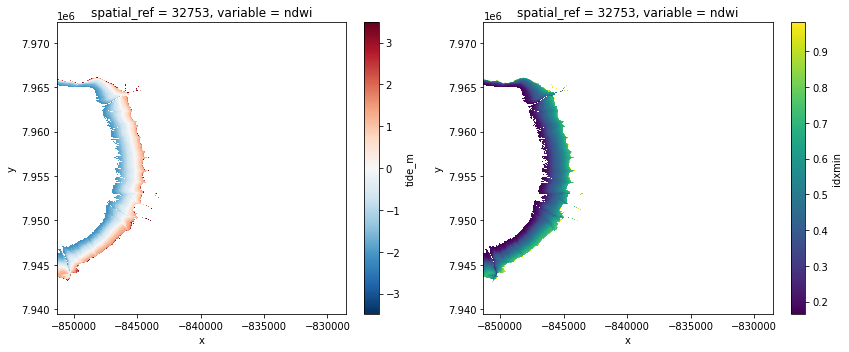

In [55]:
#### Working code calculating pixel based quantiles of tide heights using NIDEM pixels

## Temp copy for use during method development
DEM = dem.copy(deep=True)
DEM = DEM.to_dataset()
DEM = DEM.drop('tide_m')
# DS = DS.drop('ndwi')
# DS = DS.drop('tide_m')

## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '2010-12-01 00:00:00'
time_end = '2011-12-01 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='360min'

# Generate range of times covering entire period of satellite record
all_timerange = pd.date_range(start=time_start,
                              end=time_end,
                              freq=modelled_freq)
## At this point, I made a copy of the original ds, dropped the variables 
## and replaced the time array with `all_timerange` to produce an xr.Dataset
## with the same pixel coords as ds but with the whole desired modelled
## time-period
DEM['time'] = all_timerange

## Reproduce the pixel-based tides workflow from the above cell/notebook-section 
## using the copied and revised DS
# DS['tide'], _ = tqdm(pixel_tides(DS, resample=True, directory='~/dev_intexp/dea-notebooks/tide_models_clipped')) # CP pointing to clipped tide models elsewhere in sandbox

## Test pixel_tides calculation using `calculate_quantiles` option as possible cumfreq func replacement
pc_range = np.linspace(0,1,1001)
DEM['tide_cq'], DEM['lowres_tide_cq'] = tqdm(pixel_tides(DEM, 
                                             resample=True, 
                                             directory='~/dev_intexp/dea-notebooks/tide_models_clipped',
                                             calculate_quantiles = pc_range)) # CP pointing to clipped tide models elsewhere in sandbox

## Replace pixel-based NIDEM values
DEM['tide_m'] = dem

# DEM

## Calculate the difference between NIDEM value and all quartile values per pixel
DEM['diff'] = abs(DEM.tide_cq - DEM.tide_m)
## Take the smallest difference as representing the exposure percentile
DEM['idxmin'] = DEM['diff'].idxmin(dim='quantile')

#DEM

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
DEM.tide_m.plot(ax=ax1)
DEM['idxmin'].plot(ax=ax2)
fig.tight_layout()

In [63]:
plt.plot(DEM.tide_m, DEM.idxmin)
# DEM

AttributeError: 'function' object has no attribute 'values'

In [ ]:
# ## Test - slow looping version to calculate pixel exposure from pixel nidem

# for z in range(0,10):
# #     print (dem.isel(z=z).values)
#     print (dem.isel(z=z).z.values)
#     print (tide_thresh.isel(z=z).z.values)
#     print (interval_ds.isel(z=z).z.values)
#     print ('-----')
#     print (test.isel(z=z).z.values)
#     print ('---')
# #     print (test_DS_flat.isel(z=z).z.values)
#     print (DS_flat.tide_cq.isel(z=z).z.values)
#     print (ds_flat.tide_m.isel(z=z).z.values)
#     print (dem_flat.tide_cq.isel(z=z).z.values)
#     print ('----------------')
#     print ((dem.isel(z=z).z.values) == (DS_flat.tide_cq.isel(z=z).z.values))
#     print ('----------------')
    


In [ ]:
# test_transposed = dem.transpose(transpose_coords=True)
# test_transposed

In [ ]:
# # dem
# # DS_flat
# # len(DS_flat.z)
# dem.isel(z=0).values[np.abs(dem.isel(z=0).values - DS_flat.tide_cq.isel(z=0).values).argmin]

In [ ]:
# def find_nearest(a,a0):
#     "Element in nd array `a` closest to the scalar value `a0`"
#     idx = np.abs(a - a0).argmin()
#     return a.flat[idx]
# test_exp = DS_flat.apply_ufunc(find_nearest,
#                                dem,
#                                DS_flat,
#                                input_core_dims=[[]],
#                                output_core_dims = [[]],
#                                vectorise=True
#                               )
                                

In [ ]:
# DEM#tide_m.x

In [ ]:
# DEM_flat = DEM.stack(z=('x','y'))
# DEM_flat

In [ ]:
# DEM_coords = DEM.set_coords('tide_cq')
# DEM_coords

# test_exp = DEM_coords.sel(tide_cq=(DEM_coords.tide_m.where......

# IsIn = DEM_flat.isel(z=0).tide_cq.isin([DEM_flat.isel(z=0).tide_m.values])
# IsInTrue = np.where(IsIn)
# IsInTrue

# DEM.tide_m.values

In [ ]:
# IsIn = DEM_flat.tide_cq.isin([DEM_flat.tide_m.values])
# IsInTrue = xr.where(IsIn)
# IsInTrue

In [ ]:
# DEM_flat.tide_m.isel(z=1).values
# DEM_flat.isel(z=0).tide_m.values
# DEM_flat.isel(z=0).tide_cq

In [ ]:
# # test = DEM.tide_cq.isel(x=0,y=0).sel(x=DEM.tide_m.isel(x=0,y=0), method='nearest')
# test = DEM_flat.isel(z=1).tide_cq.sel(z=DEM_flat.tide_m, method='nearest')
# test

In [ ]:
# # test_exp = DEM.sel(tide_cq=tide_m, method='nearest')
# test_exp = DEM.quantile.where(DEM.tide_cq == DEM.tide_m, method='nearest')
# test_exp

# # for z in range(0,10):
    
# # #     print (dem.isel(z=z).z.values)

In [ ]:
# DEM.tide_cq.sel(x=([DEM.tide_m.values]), method='nearest')

In [ ]:
# ## Calculate exposure and plot

# # ## Calculate the exposure dataset by indexing the NIDEM elevations against the 
# # ## relative cumulative frequencies for those same elevations into a new dataset.
# Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem, method='nearest')

# # ## Also, replace nan values in NIDEM with -9999 values to enable masking of
# # ## non-intertidal areas. This is a workaround for the .sel function failing to handle
# # ## nans in the original NIDEM dataset.
# Exp_cf = Exposure.cumfreq.where(ds2.nidem.fillna(-9999) != -9999)

In [ ]:
# ## TEMP: Cell copied from CP's exposure workflow. 

# ## Calculate the cumulative frequency distribution of the modelled tides
# ## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html

# ## Extract modelled tideheights as np.array
# modelledtides = (np.array(filters[keys[n]].tideheights))

# ## Convert erroneous values to NaNs. This was an issue in the calculation of 'lowtide'. 
# ## TODO: check why erroneous values occurred at all.
# modelledtides = pd.to_numeric(modelledtides, errors='coerce')

# ## Drop nan values from the tideheight array
# ## `~` is equivalent to np.logical_not after 
# ## https://www.geeksforgeeks.org/how-to-remove-nan-values-from-a-given-numpy-array/
# modelledtides = modelledtides[~(pd.isnull(modelledtides))]

# ## Calculate number of bins to use in cumulative frequency calculation, ensuring continentally 
# ## consistent bin size of 0.05m (arbitrary bin size)
# binsize = 0.01
# bins = (modelledtides.max() - modelledtides.min())/binsize

# ## Calculate cumulative frequencies
# res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# # Calculate space of values for x
# x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

# ## Save the *relative* cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights

# CFdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
# CF_df = pd.DataFrame(data=CFdict)

# ## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
# shifted = CF_df.tideheight_max.shift(periods=1)
# updatedvalue = CF_df.tideheight_max[0] - binsize
# shifted.update(pd.Series([updatedvalue], index=[0]))

# CF_df['tideheight_min']=shifted

# CF_df['Elevation_midpoint'] = (CF_df.tideheight_max + CF_df.tideheight_min)/2
# CF_df = CF_df.set_index('Elevation_midpoint')

# ## Create xarray object from cumulative frequency dataframe
# CF_ds = xr.Dataset.from_dataframe(CF_df)


# ## Calculate exposure and plot

# # ## Calculate the exposure dataset by indexing the NIDEM elevations against the 
# # ## relative cumulative frequencies for those same elevations into a new dataset.
# Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem, method='nearest')

# # ## Also, replace nan values in NIDEM with -9999 values to enable masking of
# # ## non-intertidal areas. This is a workaround for the .sel function failing to handle
# # ## nans in the original NIDEM dataset.
# Exp_cf = Exposure.cumfreq.where(ds2.nidem.fillna(-9999) != -9999)

# ## Plot
# # Exp_cf.plot(cmap='RdYlGn', figsize=(10,5))

# ## Visualise the distribution of observations in the tidal model dataset and the relative CF distribution

# fig = plt.figure(figsize=(10, 8))
# ax1 = fig.add_subplot(2,2,1)#(1, 2, 1)
# ax2 = fig.add_subplot(2,2,2)#(1, 2, 2)
# ax3 = fig.add_subplot(2, 2, 3)
# ax1.hist(modelledtides, bins=100)
# ax1.set_title('Histogram')
# ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
# ax2.set_title('Relative cumulative frequency')
# ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
# ax2.set_xlabel('Modelled tide height (m)')
# ax2.set_xlim([x.min(), x.max()])
# # ax3.plot(Exp_cf)
# Exp_cf.plot(ax=ax3, cmap='RdYlGn')
# plt.title(str(keys[n]) + ' exposure')
# fig.tight_layout()

In [ ]:
# # ## Calculate the exposure dataset by indexing the NIDEM elevations against the 
# # ## relative cumulative frequencies for those same elevations into a new dataset.
# Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem, method='nearest')

# # ## Also, replace nan values in NIDEM with -9999 values to enable masking of
# # ## non-intertidal areas. This is a workaround for the .sel function failing to handle
# # ## nans in the original NIDEM dataset.
# Exp_cf = Exposure.cumfreq.where(ds2.nidem.fillna(-9999) != -9999)

In [ ]:
# ## Save the *relative* cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights

# CFdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
# CF_df = pd.DataFrame(data=CFdict)

# ## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
# shifted = CF_df.tideheight_max.shift(periods=1)
# updatedvalue = CF_df.tideheight_max[0] - binsize
# shifted.update(pd.Series([updatedvalue], index=[0]))

# CF_df['tideheight_min']=shifted

# CF_df['Elevation_midpoint'] = (CF_df.tideheight_max + CF_df.tideheight_min)/2
# CF_df = CF_df.set_index('Elevation_midpoint')

# ## Create xarray object from cumulative frequency dataframe
# CF_ds = xr.Dataset.from_dataframe(CF_df)


# ## Calculate exposure and plot

# # ## Calculate the exposure dataset by indexing the NIDEM elevations against the 
# # ## relative cumulative frequencies for those same elevations into a new dataset.
# Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem, method='nearest')

# # ## Also, replace nan values in NIDEM with -9999 values to enable masking of
# # ## non-intertidal areas. This is a workaround for the .sel function failing to handle
# # ## nans in the original NIDEM dataset.
# Exp_cf = Exposure.cumfreq.where(ds2.nidem.fillna(-9999) != -9999)

## Robbi's experimental - not tested or working
### Extents layer

In [ ]:
# # Calculate percent of astronomical tide range for each intertidal pixel
# astro_tides, _ = pixel_tides(
#     ds,
#     times=pd.date_range(start="2000", end="2021", freq="5H"),
#     calculate_quantiles=[0.0, 1.0],
#     resample_func=_reproject,
#     directory='~/tide_models_clipped'
# )
# astro_tide_min, astro_tide_max = astro_tides.groupby("quantile")
# astro_tide_min, astro_tide_max = astro_tide_min[1], astro_tide_max[1]
# tide_perc_da = ((dem - astro_tide_min) * 100) / (astro_tide_max - astro_tide_min)

# # Identify pixels that were always wet or always dry across rolling medians
# nontidal_dry_da = always_dry.unstack("z").reindex_like(ds).transpose('y', 'x') == True
# nontidal_wet_da = tide_thresh.isnull().unstack("z").reindex_like(ds).transpose('y', 'x') == True

# # Create integer array with 0 = always observed as land, 100 = always observed
# # as water, and remaining values the % of the astronomical tide range represented
# # by each pixel of intertidal terrain
# extents_da = (
#     odc.geo.xr.xr_zeros(ds.odc.geobox)  # create empty array
#     .where(freq > 0.5, 100)  # Set mostly dry pixels to 100, and leave mostly wet as 0
#     .where(~nontidal_dry_da, 100)  # Set any non-tidal dry pixels to 100
#     .where(~nontidal_wet_da, 0)  # Set any non-tidal wet pixels to 0
#     .where(tide_perc_da.isnull(), tide_perc_da.clip(0, 100))  # Fill intertidal with %s
# ).astype(np.uint16)

# # Ensure CRS is present
# # extents_da = extents_da.odc.assign_crs(ds.odc.geobox.crs)

# extents_da.odc.write_cog(
#     fname=f"data/interim/pixel_{fname}_extents.tif", overwrite=True
# )

In [ ]:
# # Clean data using morphological opening to remove narrow inland 
# # streams and waterbodies
# clean=[("opening", 20), ("dilation", 10)]
# to_keep = mask_cleanup(extents_da < 100, mask_filters=clean)
# dem_clean = dem.where(to_keep)

# # Export to file
# dem_clean.odc.write_cog(
#         fname=f"data/interim/pixel_{fname}_{suffix}_cleaned.tif", overwrite=True
#     )

In [ ]:
# test = ds.tide_m.mean(dim=['x', 'y'])

### Remove water not attached to ocean

In [ ]:
# from skimage.measure import label, regionprops

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, to_keep, 0, False, 1)

# # Get blob ID for each blob inside ocean area
# ocean = dc.load(product="geodata_coast_100k", like=ds.odc.geobox.compat).land == 0
# ocean_blobs = np.unique(blobs.where(ocean, 0))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

In [ ]:
# ocean_mask.plot()

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, ds, 1, False, 1)

# # Get blob ID for each tidal modelling point
# x = xr.DataArray(tide_points_gdf.geometry.x, dims="z")
# y = xr.DataArray(tide_points_gdf.geometry.y, dims="z")
# ocean_blobs = np.unique(blobs.interp(x=x, y=y, method="nearest"))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

# # Dilate mask so that we include land pixels on the inland side
# # of each shoreline to ensure contour extraction accurately
# # seperates land and water spectra
# if dilation:
#     ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

# return ocean_mask

### Regression experiment

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
ds_subset = interval_ds.where((interval_ds.ndwi > 0.05) & (interval_ds.ndwi < 0.25))
linreg = lag_linregress_3D(x=ds_subset.tide_m, y=ds_subset.ndwi, first_dim='interval')

In [ ]:
# linreg.intercept.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
# linreg.slope.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
testing = ((0 - linreg.intercept) / linreg.slope).where(linreg.pval < 0.01).unstack("z").reindex_like(ds)  #.plot.imshow(vmin=-1, vmax=0.5)

In [ ]:
testing = testing.where(testing > ds_subset.tide_m.min())

In [ ]:
testing.T.odc.write_cog(fname=f'data/interim/pixel_linreg7.tif', overwrite=True)

In [ ]:
y = mx + a
(y - a) / m

In [ ]:
ds.geobox

In [ ]:
quantile_ds.tide_m.where(quantile_ds.ndwi <= 0.1).dropna(dim='z', how='all')

In [ ]:
(tide_argmax + 1).unstack("z").reindex_like(ds).T.plot()

In [ ]:
tide_dry.isel(interval=(tide_argmax - 1).clip(0, len(tide_dry.interval) - 1))

In [ ]:
tide_dry.isel(tide_argmax)

In [ ]:
tide_argmax + 1

In [ ]:
tide_dry.dropna(dim='interval', how='all').argmax(dim='interval', axis=1)

In [ ]:
interval_ds

In [ ]:
# # Output name
# fname = 'testing1'
# # fname = aoi.lower().replace(' ', '')

# # Calculate 
# confidence = interval_ds.ndwi_std.mean(dim='interval')
# min_thresh = (0 - 0.5 * confidence)
# max_thresh = (0 + 0.5 * confidence)

# for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
#     dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
#     print(f'Exporting {dem_fname}')
    
#     # Identify the max tide per pixel where NDWI == land
#     tide_thresh = interval_ds.tide_m.where(interval_ds.ndwi <= thesh).max(dim='interval')
#     tide_max = interval_ds.tide_m.max(dim='interval')
    
#     # Remove any pixel where tides max out (i.e. always land)
#     dem = tide_thresh.where(tide_thresh < tide_max)
    
#     # Export DEM file  
# #     dem.T.odc.write_cog(fname=dem_fname, overwrite=True)
#     dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).T.odc.write_cog(fname=dem_fname, overwrite=True)
    

# # Export NDWI standard deviation/confidence file
# confidence.T.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

In [ ]:
# dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).plot()

In [ ]:
# dem.where(~(tide_thresh.isnull() & (freq > 0.90)), dem.min()).plot()

In [ ]:
interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest')

In [ ]:
x, y = -1156521.12372093, 7712141.96160016
ndwi_thresh = 0.0

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sortby(["interval", "x", "y"]).sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)


# clipped = pixel_rolling.where((pixel_rolling.ndwi > 0) & (pixel_rolling.ndwi < 0.1)).dropna()

# ax.plot(clipped.tide_m, clipped.ndwi, '-o', color='green')
# from scipy import stats
# linreg = stats.linregress(x=clipped.tide_m, y=clipped.ndwi)
# x = np.linspace(pixel_raw.tide_m.min(), pixel_raw.tide_m.max())
# # ax.plot(x, [linreg.slope * i + linreg.intercept for i in x], color='green', linestyle='--')
# tide_thresh_3 = (ndwi_thresh - linreg.intercept) / linreg.slope

# rolling2 = pixel_raw.sort_values('tide_m').rolling(100, center=True, min_periods=1).median()
# ax.plot(rolling2.tide_m, rolling2.ndwi, '-o', color='red')



# tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
# tide_thresh_2 = pixel_rolling.tide_m.iloc[max_ind + 1]

# ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
# ax.axvline(tide_thresh_2, color='red', linestyle='--', lw=0.8, alpha=0.5)
# ax.axvline(tide_thresh_3, color='green', linestyle='--', lw=2, alpha=0.5)
# ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
x, y = 801144.14604825, 8189103.58475355
ndwi_thresh = 0.1

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
(pixel_rolling.ndwi * (10* pixel_rolling.ndwi.abs())).plot()

In [ ]:
ds_sub = ds.sel(x=x,  y=y, method='nearest')


ds_sub.sel(time=(ds_sub.ndwi < 0) & (ds_sub.tide_m > 0.25)).time

In [ ]:
from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_rolling.ndwi.values, 50, 2) # window size 51, polynomial order 3
plt.plot(yhat)

In [ ]:
test = np.array([-0.5, -0.2, -0.01, 0, 0.01, 0.2, 0.5])

In [ ]:
import scipy.stats
plt.plot(scipy.stats.norm.pdf(test, loc=0, scale=1))

In [ ]:
from skimage import exposure

In [ ]:
plt.plot(test)

In [ ]:
plt.plot(exposure.adjust_gamma(np.abs(test), 2))

In [ ]:



from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_raw.ndwi.values, 25, 3) # window size 51, polynomial order 3

pixel_rolling.ndwi.plot()
plt.plot(yhat)

In [ ]:
pixel_raw.ndwi.plot()

In [ ]:
interval_ds.ndwi2

In [ ]:
clipped_test = pixel_rolling.where((pixel_rolling.ndwi > -0.1) & (pixel_rolling.ndwi < 0.1)).dropna().rolling(5, center=True).mean()
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

diff = clipped_test.ndwi.diff() / clipped_test.ndwi.index.to_series().diff()
plt.plot(clipped_test.tide_m, diff, '-o', color='red')

plt.axvline(clipped_test.tide_m.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.axhline(clipped_test.ndwi.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)

In [ ]:
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

In [ ]:
pdf = gaussian_kde(pixel_rolling.ndwi.values, bw_method=0.5, weights=scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))
x = np.linspace(-0.5, 0.5, 200)
y = pdf(x)
plt.axvline(x[y.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.plot(x, y, label='kde')

In [ ]:
from scipy.stats import gaussian_kde


In [ ]:
import scipy.stats
plt.scatter(pixel_rolling.ndwi.values, scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))

In [ ]:
pixel_raw.tide_m.min()

In [ ]:
pixel_raw.ndwi.plot.density(bw_method=0.05)

In [ ]:
pixel_rolling.ndwi.plot()
(pixel_rolling.ndwi.diff() / pixel_rolling.ndwi.index.to_series().diff()).plot()

In [ ]:
from scipy.signal import savgol_filter
w = savgol_filter(y.sort_values('ndwi').ndwi, 5, 2)
w

In [ ]:
y.sort_values('tide_m').ndwi

In [ ]:
# tide_thresh_2 = 


In [ ]:
pixel_rolling.where(pixel_rolling.ndwi < 0).tide_m.argmax()

In [ ]:
x, y = 642456.7107189415, 8275569.497920433
pixel = interval_ds.sel(x=x,  y=y, method='nearest')
df_median = pixel.to_dataframe().reset_index()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_m, y=df_median.ndwi)
tide_thresh_1 = df_median.where(df_median.ndwi < 0).tide_m.max()
tide_thresh_2 = df_median.where(df_median.ndwi > 0).tide_m.min()
ax.axvline((tide_thresh_1 + tide_thresh_2) / 2)
ax.axhline(0)

### Elevation calculation

In [ ]:
# Output name
fname = 'testing1'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file  
    dem.odc.write_cog(fname=dem_fname, overwrite=True)

# Export NDWI standard deviation/confidence file
s2_stdev_mean.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

### Experimental

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

In [ ]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
# from dask_gateway import Gateway
# gateway = Gateway()

# # Close any existing clusters
# cluster_names = gateway.list_clusters()
# if len(cluster_names) > 0:
#     print("Cluster(s) still running:", cluster_names)
#     for n in cluster_names:
#         cluster = gateway.connect(n.name)
#         cluster.shutdown()

In [ ]:
# cluster.shutdown()